Let us attempt this problem with 5x5 echelle diagrams, make the code calculate the actual delta nu value (large separation between consecutive n modes) with median and with mean. 

Computed Δν (median method): 1.753
Computed Δν (mean method): 1.342


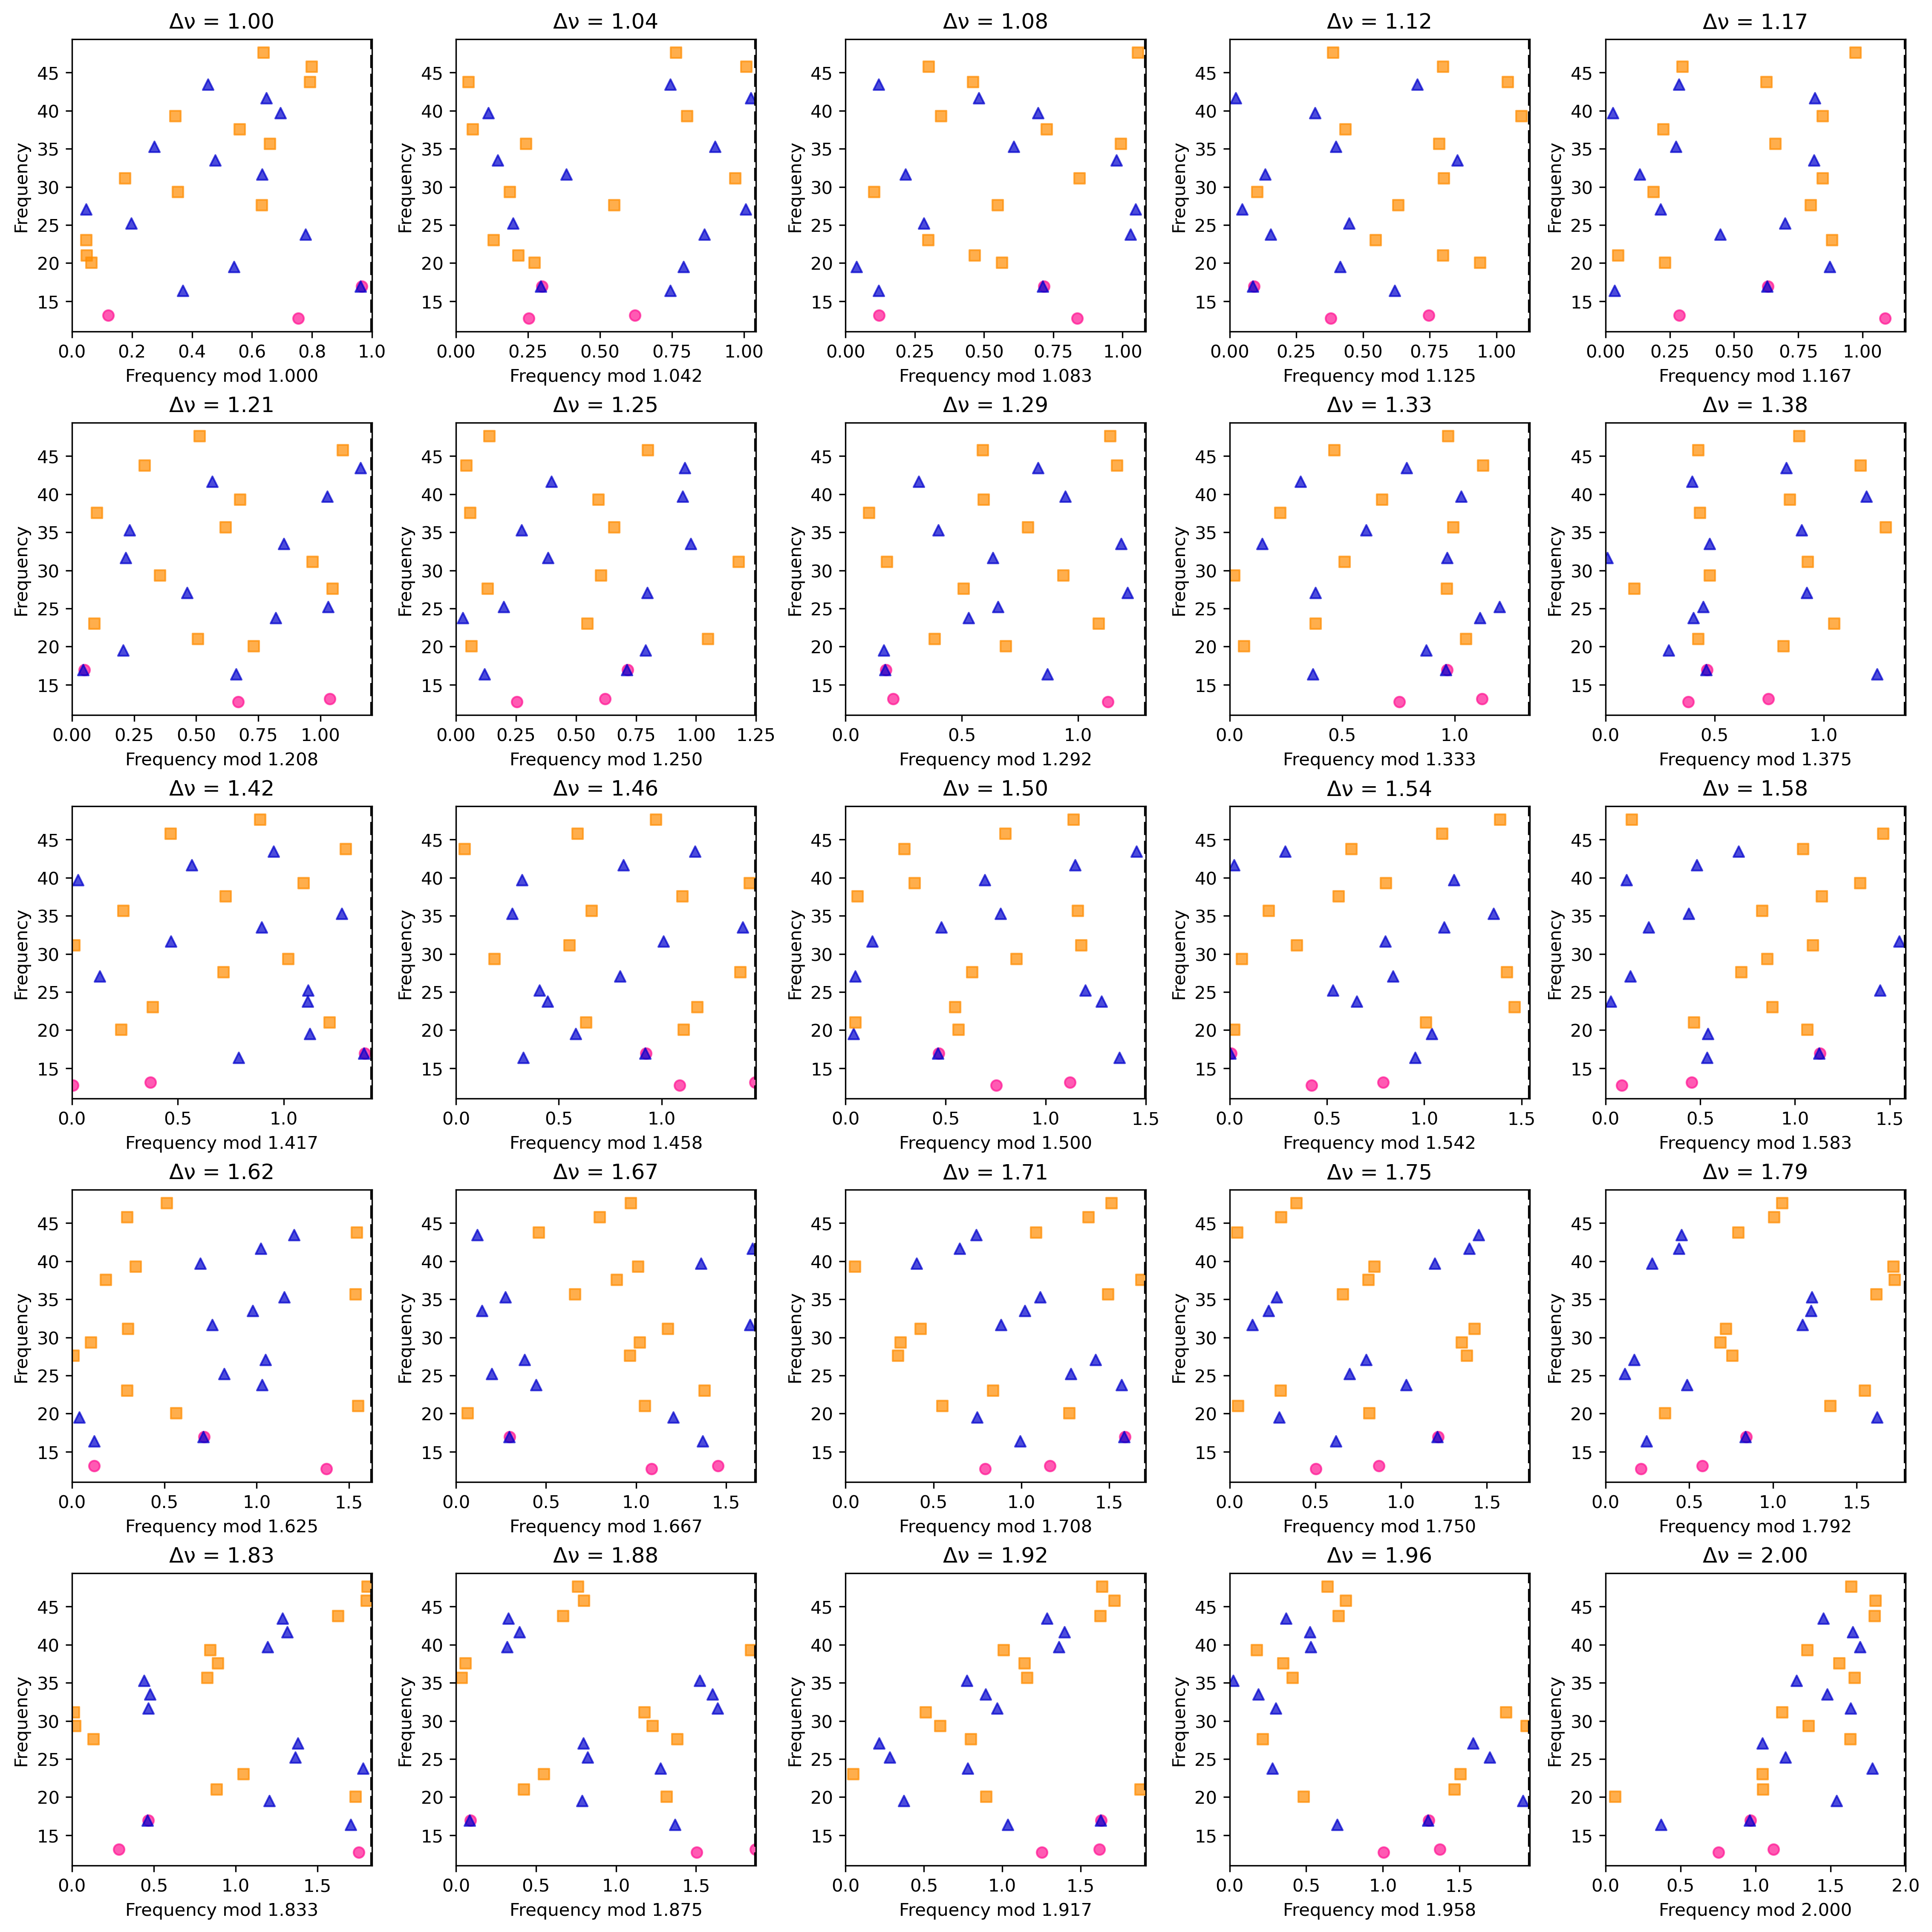

In [27]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# so here we use two methods to calculate the large separation - median and mean


data = pd.read_feather('pre-ms-models_database/10_dim_grid/Teff_10000-10250_logg_4.1-4.2_z_0.006_he_0.204.feather')
example_model = data[data["model_id"] == data["model_id"].unique()[0]]

# so first of all we just read in the data, sort the frequencies and compute the large separation (delta nu between two ridges) with 2 methods
def compute_large_separation(frequencies):
    
    sorted_freqs = np.sort(frequencies)
    delta_nu_vals = np.diff(sorted_freqs) 

    median_dnu = np.median(delta_nu_vals)
    mean_dnu = np.mean(delta_nu_vals)

    return median_dnu, mean_dnu

def plot_echelle(ax, model_data, delta_nu):

    mode_frequencies = {
        0: model_data['F'].values,  # l = 0 (radial modes)
        1: model_data[['O1', 'O3', 'O5', 'O7']].values.flatten(),  # l = 1 (dipole)
        2: model_data[['O2', 'O4', 'O6', 'O8']].values.flatten()  # l = 2 (quadrupole)
    }
    
    # remove NaN values
    for l in mode_frequencies:
        mode_frequencies[l] = mode_frequencies[l][~np.isnan(mode_frequencies[l])]

    # advanced method to define colors and markers (thanks chatgpt)
    l_colors = {0: 'deeppink', 1: 'mediumblue', 2: 'darkorange'}
    l_markers = {0: 'o', 1: '^', 2: 's'}

    # plot each mode separately
    for l, freqs in mode_frequencies.items():
        if len(freqs) == 0:  # avoid empty arrays
            continue
        
        mod_frequencies = freqs % delta_nu # folding the frequencies with modulo
        ax.scatter(mod_frequencies, freqs, c=l_colors[l], marker=l_markers[l], label=f'l = {l}', alpha=0.7)

    # reference line to repeat the periodic ridges
    ax.axvline(delta_nu, color='black', linestyle='--', linewidth=2)

    # juts some formating stuff
    ax.set_ylabel('Frequency')
    ax.set_xlabel(f'Frequency mod {delta_nu:.3f}')
    ax.set_xlim(0, delta_nu)
    ax.set_title(f"Δν = {delta_nu:.2f}")

# calculate reference delta nu values
all_frequencies = np.concatenate([
    example_model['F'].values, 
    example_model[['O1', 'O3', 'O5', 'O7']].values.flatten(),
    example_model[['O2', 'O4', 'O6', 'O8']].values.flatten()
])
all_frequencies = all_frequencies[~np.isnan(all_frequencies)]  # Remove NaNs once again

median_dnu, mean_dnu = compute_large_separation(all_frequencies) # and then HERE we actually use the function we defined above to find
                                                                 # delta nu in two different ways
print(f"Computed Δν (median method): {median_dnu:.3f}")
print(f"Computed Δν (mean method): {mean_dnu:.3f}")

# 25 x values, use either linspace or geomspace
delta_nus = np.linspace(1, 2, 25)

# 25 x echelle diagrams
fig, axes = plt.subplots(5, 5, figsize=(15, 15), constrained_layout=True, dpi=300)

for ax, delta_nu in zip(axes.flat, delta_nus):
    plot_echelle(ax, example_model, delta_nu)
plt.show()


## New approach! I don't know what happened up there..

And also with drawing some inspiration from the pre-ms-database code, because neither I nor ChatGPT understand how to do this.

4.0746


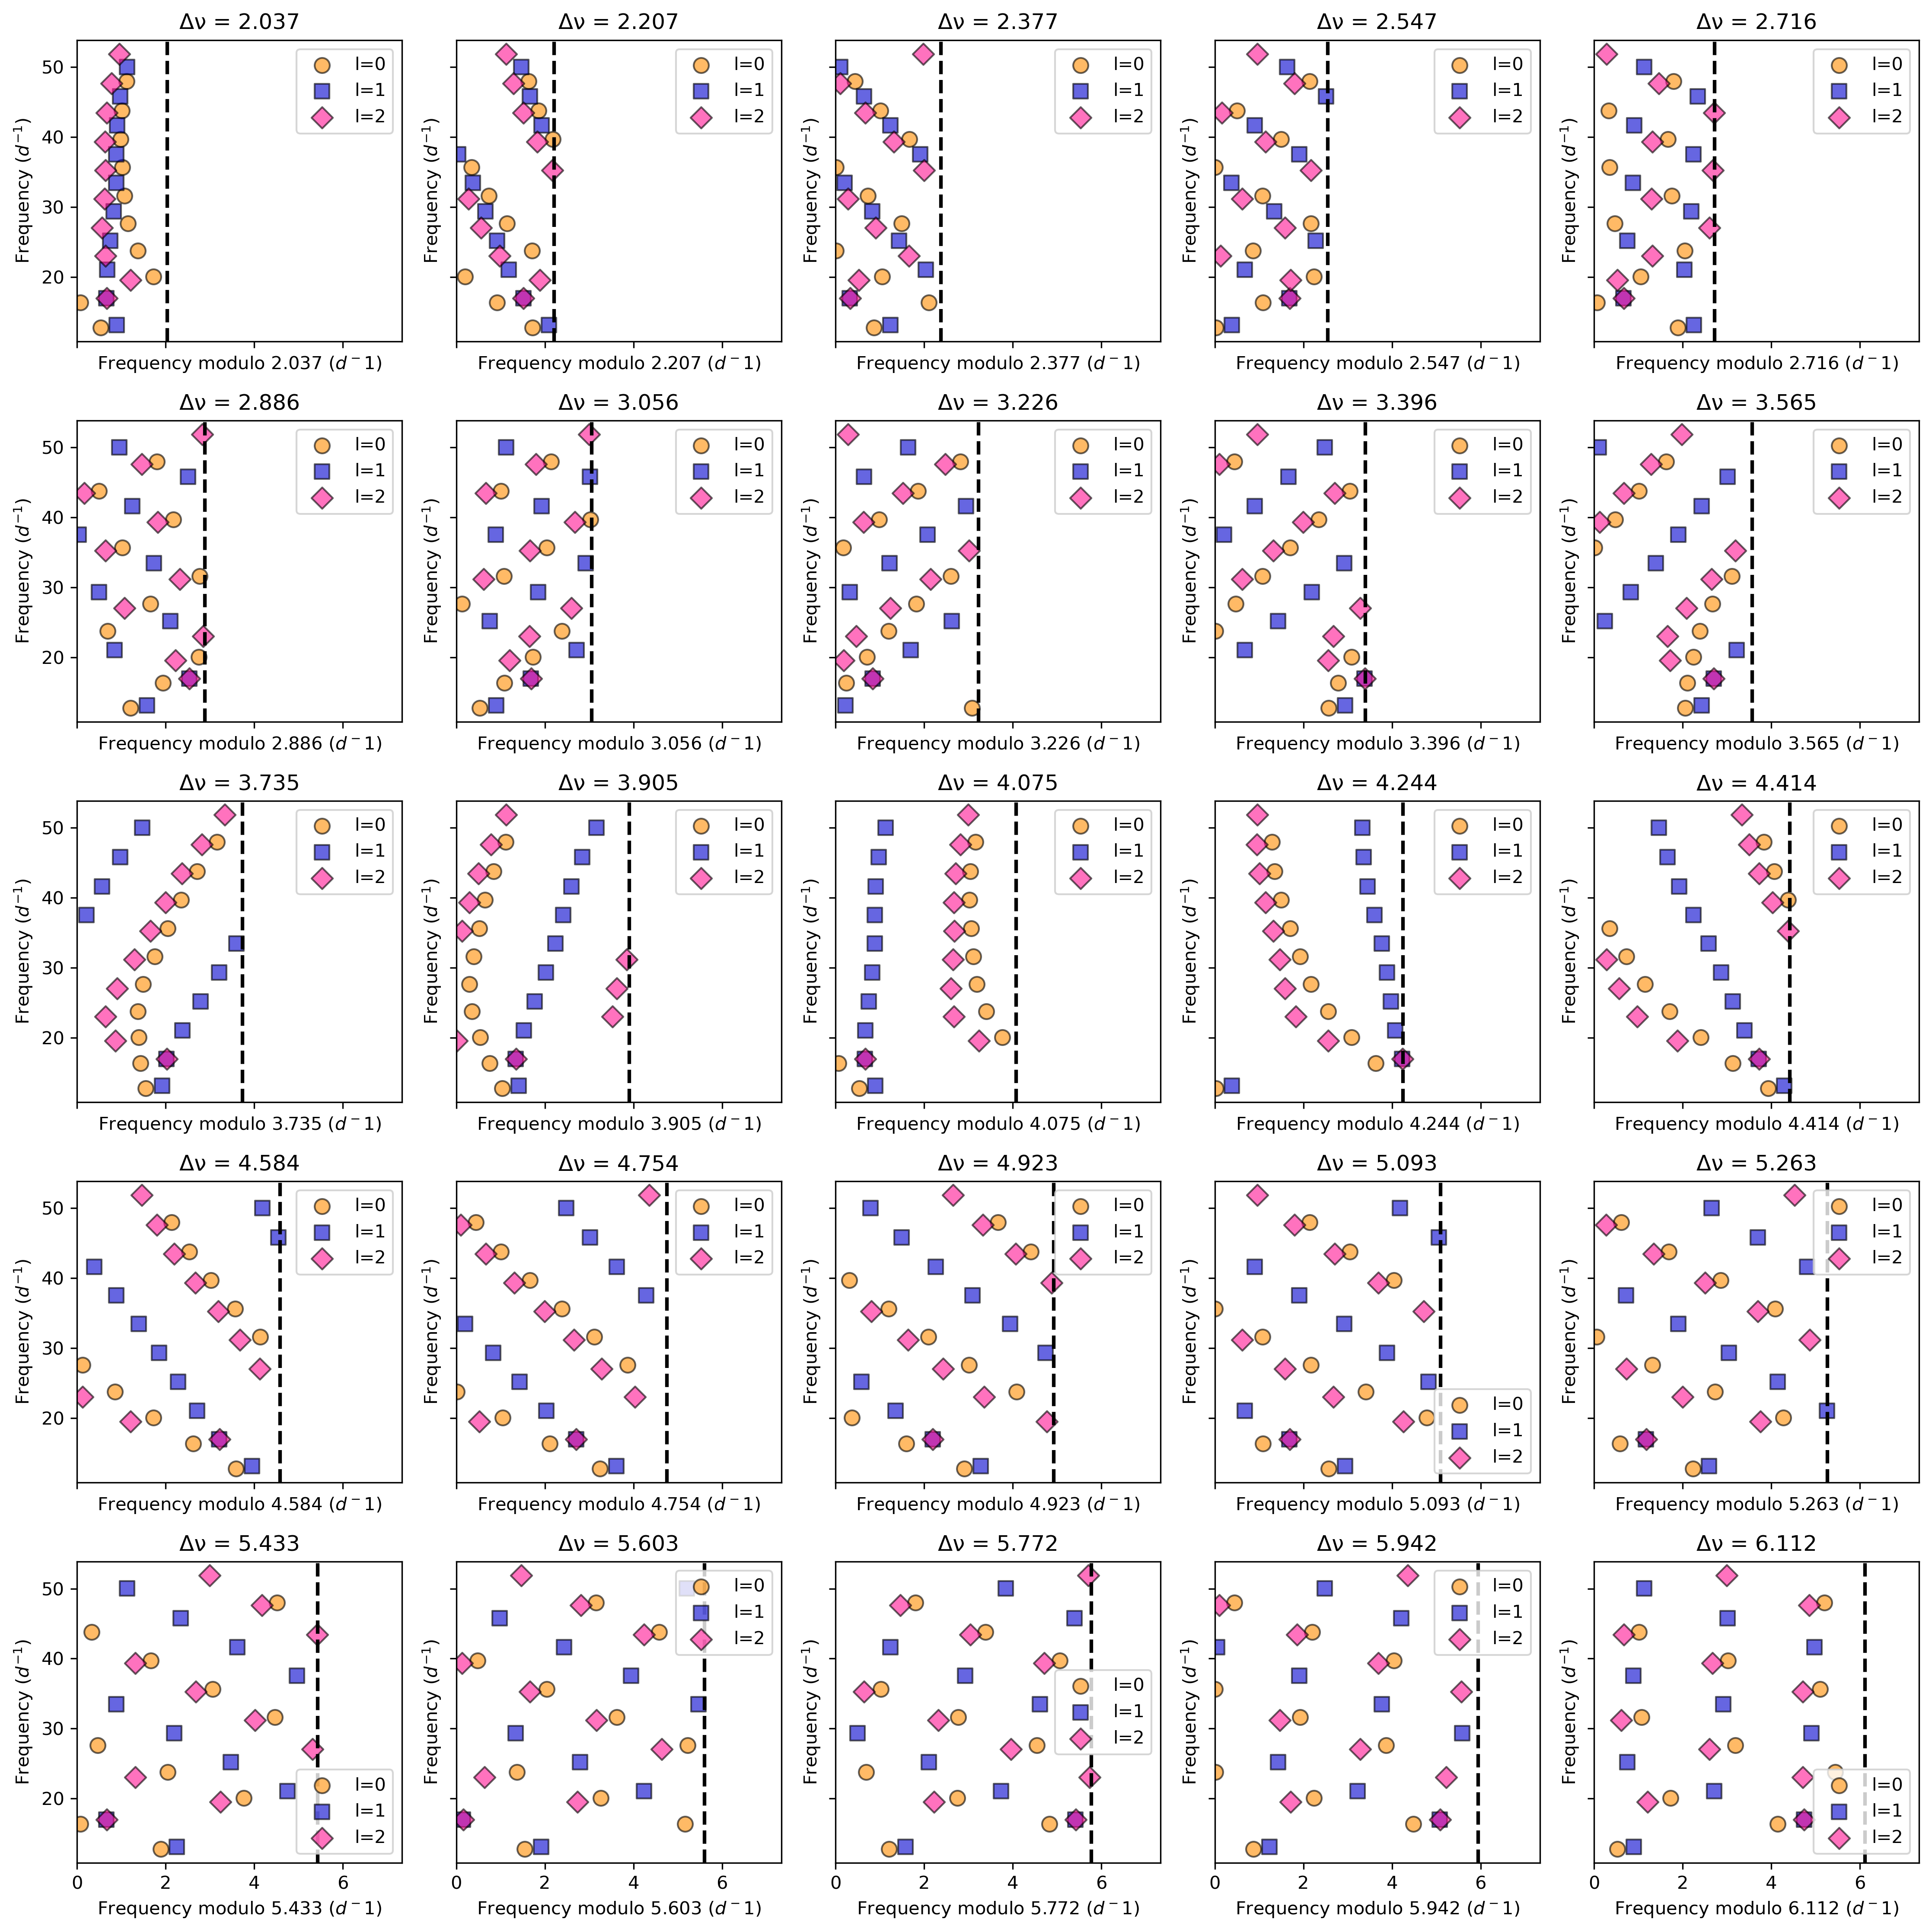

In [25]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pyarrow.feather as feather

# loading file and extracting frequencies, so fundamental and overtone
file_path = "pre-ms-models_database/10_dim_grid/Teff_10000-10250_logg_4.1-4.2_z_0.006_he_0.204.feather"
model_data = feather.read_feather(file_path)
mode_columns = ['F', 'O1', 'O2', 'O3', 'O4', 'O5', 'O6', 'O7', 'O8', 'O9']

# thanks to the database
class modelling_ridge():
    def __init__(self, f_dict, l): 
        self.l = l  # store mode degree (l-value)
        
        # extract and store frequency values, ignoring NaNs
        self.fvals = np.array([f_dict[key] for key in mode_columns if pd.notna(f_dict[key])])
        # pd.notna detects non-missing values for an array-like object. the output is boolean

        if len(self.fvals) > 1:
            # compute large frequency separations (Δν values)
            self.delta_nu_vals = self.fvals[1:] - self.fvals[:-1]
            self.delta_nu = np.median(self.delta_nu_vals) # take median as the representative Δν bc that's what's done in database code
        else:
            self.delta_nu_vals = []
            self.delta_nu = 0  # prevents errors if there's only one frequency

# function to plot ONE echelle diagram 
def plot_echelle(ax, ridges, dnu):
    colors = {0: "darkorange", 1: "mediumblue", 2: "deeppink"}  
    markers = {0: "o", 1: "s", 2: "D"}  

    for r in ridges: # plot frequencies modulo Δν to create ridge structures
        ax.scatter(r.fvals % dnu, r.fvals, c=colors[r.l], marker=markers[r.l], 
                   edgecolors='black', alpha=0.6, s=70, label=f'l={r.l}')

    ax.axvline(dnu, color='black', ls='--', lw=2)  # vertical reference line at Δν
    ax.set_ylabel('Frequency $(d^{-1})$')
    ax.set_xlabel(f'Frequency modulo {dnu:.3f} $(d^{-1})$')
    ax.set_xlim(0, dnu * 1.2)
    ax.legend()

# function to plot a nxn grid of echelle diagrams
def plot_echelle_grid(ridges):
    fig, axes = plt.subplots(5, 5, figsize=(15, 15), sharex=True, sharey=True, dpi = 300)

    # compute median Δν across all ridges
    median_dnu = np.mean([r.delta_nu for r in ridges if r.delta_nu > 0])
    dnu_range = np.linspace(0.5 * median_dnu, 1.5 * median_dnu, 25)  # n Δν values, here we could also set linspace to geomspace
    print(median_dnu)
    
    for i, ax in enumerate(axes.flat):
        dnu = dnu_range[i]  # select Δν for this subplot
        plot_echelle(ax, ridges, dnu)  # plot echelle diagram
        ax.set_title(f"Δν = {dnu:.3f}", fontsize=12)
    plt.tight_layout()
    plt.show()

# choose a model (closest to reference)
closest_point = 0  
echelle_df = model_data[model_data["model_id"] == model_data["model_id"].iloc[closest_point]] # also something that's done in database

# separate ridges by l-value
ridges = []
          
for l in [0, 1, 2]:
    r_data = echelle_df[echelle_df["l_val"] == l][mode_columns].to_dict('records')
    if r_data:
        ridges.append(modelling_ridge(r_data[0], l))  # create ridge object for each l-value

plot_echelle_grid(ridges)